#  Fine-tuning GPT3.5 with the OpenAI API




## Data
This case study uses the Yahoo Non-Factoid Question Dataset derived from the Yahoo’s Webscope L6 collection
- It has 87,361 questions and their corresponding answers.  
- Freely available from [Hugging Face](https://huggingface.co/datasets/yahoo_answers_qa).  



In [2]:
%%bash 
python3 -m pip install --upgrade pip
pip -q install -U datasets
pip -q install openai==0.28

Defaulting to user installation because normal site-packages is not writeable


  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
awswrangler 2.16.1 requires pyarrow<7.1.0,>=2.0.0, but you have pyarrow 14.0.2 which is incompatible.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.


In [1]:
# Import specific classes and functions from the OpenAI library
from openai import FineTuningJob, ChatCompletion  # Used for fine-tuning models and generating chat completions

# Import the load_dataset function from the datasets library
from datasets import load_dataset  # Used for loading and working with datasets

# Import the sleep function from the time module
from time import sleep  # Used for adding delays in code execution

# Import the entire openai library
import openai  # Provides access to OpenAI's API functionalities

# Import the random module from Python's standard library
import random  # Used for generating random numbers and shuffling data

# Import the json module from Python's standard library
import json  # Used for working with JSON data

##  Data Loading  


In [3]:
# Load the training split of the 'yahoo_answers_qa' dataset and assign it to the variable
yahoo_answers_qa = load_dataset("yahoo_answers_qa", split="train")

- Check the features/columns and the total number of rows of the data

In [4]:
# Display the entire 'yahoo_answers_qa' dataset
yahoo_answers_qa

Dataset({
    features: ['id', 'question', 'answer', 'nbestanswers', 'main_category'],
    num_rows: 87362
})

- From the above command, you will notice that there are 87362 rows from the dataset, and such a huge amount of data can be long to process, especially during the fine-tuning process. 
- For simplicity's sake, let's use a subset of 500 rows from the previously loaded dataset. 
    - Use the `.select` and the `range` functions to select a subset of `500` rows    

In [5]:
# Define the number of samples to be selected from the 'yahoo_answers_qa' dataset
SAMPLE_SIZE = 500

# Select the first 500 items from the 'yahoo_answers_qa' dataset to create a smaller sample
yahoo_answers_qa = yahoo_answers_qa.select(range(SAMPLE_SIZE))

- Check the features/columns and the total number of rows of the new data with the `500` samples 

In [4]:
# Display the entire 'yahoo_answers_qa' dataset
yahoo_answers_qa

Dataset({
    features: ['id', 'question', 'answer', 'nbestanswers', 'main_category'],
    num_rows: 500
})

- Observe the distribution of the questions and answers using the helper function `show_distribution` 
- We use the `matplotlib` package to generate the graphical result

In [22]:
import matplotlib.pyplot as plt

def show_distribution(qa_dataset, column_name, label, graphic_color):
    """
    @Description:
        - shows the distribution of a given column along with a label and color
        
    @Parameters
        - qa_dataset: The dataset containing question and answer pairs.
        - column_name: The specific column whose distribution we want to visualize.
        - label: A label for the plot (used in the legend).
        - graphic_color: The color to be used for the plot.
    """
    
    # Calculate the length of each question and answer
    column_data_lengths = [len(qa[str(column_name)]) for qa in qa_dataset]

    # Plot the distribution of column data lengths
    plt.hist(column_data_lengths, bins=50, alpha=0.5, 
             color=graphic_color, label=label)

    # Add labels and a legend to the plot
    plt.xlabel('Length')
    plt.ylabel('Frequency')
    plt.title(f'Distribution of {column_name} Length')
    plt.legend()

    # Display the plot
    plt.show()

- Show the distribution of the `question` column

In [ ]:
show_distribution(yahoo_answers_qa, "question", "Question Length", "blue")

- Show the distribution of the `answer` column

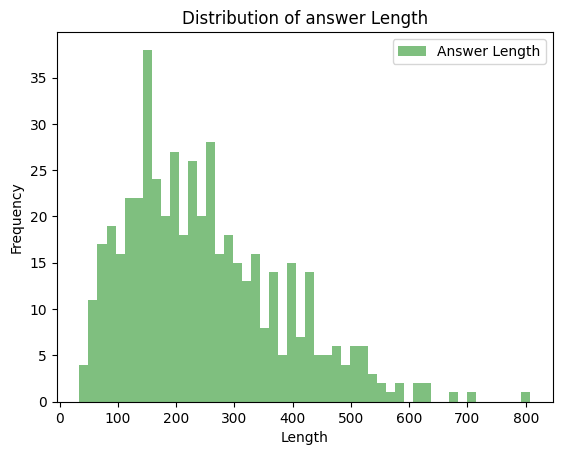

In [12]:
show_distribution(yahoo_answers_qa, "answer", "Answer Length", "green")

In [5]:
# Retrieve and display the eighth item from the 'yahoo_answers_qa' list
yahoo_answers_qa[7]

{'id': '3995851',
 'question': 'how do Elephants communicate?',
 'answer': 'There make very low frequency sounds that we cannot hear. They also make sounds that we do hear and it is because they what other animals to hear it.',
 'nbestanswers': ['There make very low frequency sounds that we cannot hear. They also make sounds that we do hear and it is because they what other animals to hear it.',
  'To expand on the previous answer... these low frequency sounds are called subsonic or infrasounds. A variety of animals hear in this range, such as elephants, whales and alligators. Your home subwoofer works on the same principle. Big benefit of subsonics is that they travel over long distances well.'],
 'main_category': 'Science & Mathematics'}

In [6]:
# Retrieve and display the last item from the 'yahoo_answers_qa' list
yahoo_answers_qa[-1]

{'id': '2027745',
 'question': 'how to open a college?',
 'answer': 'Most people look for a college that is accredited.  Because of the expenses involved I would recommend an online university.  You will need a qualified web designer to create the site and several professors to put together the courses.',
 'nbestanswers': ['Most people look for a college that is accredited.  Because of the expenses involved I would recommend an online university.  You will need a qualified web designer to create the site and several professors to put together the courses.',
  "Depends on the law in your country/state and your program, diploma policy.. Special approval is required, otherwise it's not a real college."],
 'main_category': 'Education & Reference'}

## Format the data for fine-tuning   

```json
{
    "messages": [
        {"role": "system", "content": "SYSTEM's ROLE"},
        {"role": "user", "content": "USER's QUESTION"},
        {"role": "assistant", "content": "SYSTEM's RESPONSE"}
    ] 
}


In [7]:
def format_data(data):
    """
    @Description:
        - This function takes a list of dictionaries (data) where each dictionary represents a message  
        with a question and an answer which is then formatted into a specific structure.
        - The final final result is also a list of dictionary containing the "messages" key.
        - This key maps to a list of three dictionaries respectively: 
            - A system message
            - A user's question and 
            - An assistant's answer.
    
    @Parameters:
        - data (list of dict): A list with each element is a dictionary containing 'question' and 'answer' keys.

    @Returns:
        - List of dict: A randomized list of dictionaries formatted as described above.
    """
  
  # Format each message in the data list to a specific structure
  formatted_data = [
    {"messages": [
        {
            "role": "system",
            "content": "You are the Yahoo platform user's assistant. Please reply users' answer with a polite and respectful language."
        },

        {
            'role': 'user',
            'content': message["question"]
        },

        {
            'role': 'assistant',
            'content': message["answer"]
        }]
     } for message in data
  ]
  
  # Randomize the order of the formatted data
  random.shuffle(formatted_data)
 
  return formatted_data
     

- Apply the formatting to the data

In [8]:
# Apply the 'format_data' function to the 'yahoo_answers_qa' dataset to reformat it into the desired structure
formatted_data = format_data(yahoo_answers_qa)

- Show the `08th` and last observations from the dataset to make sure that the changes have been applied 

In [9]:
# Retrieve and display the eighth item from the 'formatted_data' list
formatted_data[7]

{'messages': [{'role': 'system',
   'content': "You are the Yahoo platform user's assistant. Please reply users' answer with a polite and respectful language."},
  {'role': 'user',
   'content': 'what are the benefits of using an electric shaver?'},
  {'role': 'assistant',
   'content': "Electric shavers are faster and do not require water or foam.  On the down side, they do not shave as closely as a traditional razor, and their battery life can vary.  Also, some electric razors are significantly better than others, and their results vary more than a traditional blade.  Finally, any switch from traditional to electric or back can result in skin irritation, so it's best to be very careful when changing."}]}

In [14]:
formatted_data[-1]

{'messages': [{'role': 'system',
   'content': "You are the Yahoo platform user's assistant. Please reply users' answer with a polite and respectful language."},
  {'role': 'user',
   'content': 'how do you treat cats ear mites without going to a vet?'},
  {'role': 'assistant',
   'content': "I have used alcohol on q-tips. You can always give it a shot and if that doesn't work, then you can take your kitty to the vet."}]}

## Split the data into Training and Validation  



    - `70%` of the data is used for training   
    - The remaining `30%` is used for validation

In [11]:
# Define the size of the training dataset as 70% of the total formatted data
TRAIN_SIZE = int(len(formatted_data) * 0.7) 

# Split the formatted data into two parts: training and validation
# The first 70% of the formatted data is used for training
training_data = formatted_data[:TRAIN_SIZE]

# The remaining 30% of the formatted data is used for validation
validation_data = formatted_data[TRAIN_SIZE:]

- Use the `len` and `print` functions to display the length of the training and validation data sets 

In [ ]:
# Print the number of items in the training dataset
print(f"Training Size: {len(training_data)}")

# Print the number of items in the validation dataset
print(f"Validation Size: {len(validation_data)}")

##Save the Training and Validation data locally  


In [11]:
def save_data(dictionary_data, file_name):
  """
    @Description: 
        - Saves a list of dictionaries to a file in JSON format, with each dictionary on a new line
        
    @Parameters:
        - dictionary_data (list of dict): A list of dictionaries to be saved.
        - file_name (str): The name of the file where the data will be saved.
  """
  
  # Open the file in write mode
  with open(file_name, 'w') as outfile:
    # Iterate over each dictionary in the list
    for entry in dictionary_data:
      # Serialize the dictionary to JSON and write it to the file
      json.dump(entry, outfile)
      # Write a newline character after each dictionary
      outfile.write('\n')

In [72]:
# Save the training data
save_data(training_data, "./training_data.jsonl")
# Save the validation data
save_data(validation_data, "./validation_data.jsonl")

In [13]:
%%bash
ls

credential.txt
flagged
image.png
notebook.ipynb
training_data.jsonl
validation_data.jsonl


## : Upload the datasets into OpenAI account   
 

In [2]:
# Import the operating system library
import os
# Import the openai library
import openai

In [3]:
# Retrieve the OpenAI API key from the environment variables
openai_api_key = os.environ["OPENAI_API_KEY"]

In [4]:
def upload_fine_tuning_data(data_path):
  
  """
  @Description:
    - Uploads a file to OpenAI for the purpose of fine-tuning a model.
    
  @Parameters:
    - data_path (str): The path to the file that needs to be uploaded for fine-tuning.
    
  @Returns:
    - object: An object representing the uploaded file, as returned by the OpenAI API.

  @Note:
    - It's important to ensure that the OpenAI API key is set correctly in the environment, 
      as the function relies on the OpenAI library which uses that key for authentication.
  """
  # Create and upload the file to OpenAI using the provided file path
  oploaded_file = openai.File.create(
    file=open(data_path, "rb"),
    purpose='fine-tune'
  )

  return oploaded_file

In [7]:
# Upload the training data file to OpenAI for fine-tuning
uploaded_training_data = upload_fine_tuning_data("./training_data.jsonl")

In [8]:
uploaded_training_data

<File file id=file-c7mJO4z5iz9lfYEfiDYbXj1x at 0x7fbd9d612180> JSON: {
  "bytes": 185047,
  "created_at": 1703092443,
  "filename": "file",
  "id": "file-c7mJO4z5iz9lfYEfiDYbXj1x",
  "object": "file",
  "purpose": "fine-tune",
  "status": "processed",
  "status_details": null
}

In [9]:
# Retrieve the unique identifier of the uploaded training data
uploaded_training_id = uploaded_training_data["id"]

# Print the identifier to the console
print(uploaded_training_id)

file-c7mJO4z5iz9lfYEfiDYbXj1x


- Upload the validation data

In [12]:
# Upload the validation data file to OpenAI for fine-tuning purposes
uploaded_validation_data = upload_fine_tuning_data("./validation_data.jsonl")

- Store the id in a new variable uploaded_validation_id and print it

In [13]:
# Retrieve the unique identifier of the uploaded training data
uploaded_validation_id = uploaded_validation_data["id"]

# Print the identifier to the console
print(uploaded_validation_id)

file-BjmWwtk856LbN9Sk568QCA4S


##  Fine-tuning   



In [14]:
def create_fine_tuning(model_name, train_id, val_id):
  
  """
  @Description:
    - Initiates a fine-tuning job for a specified AI model using given training and validation files.
    
  @Parameters:
    - model_name (str): The name of the model to be fine-tuned.
    - train_id (str): The identifier of the uploaded file to be used as the training dataset.
    - val_id (str): The identifier of the uploaded file to be used as the validation dataset.
    
  @Returns:
    - object: An object representing the response from the fine-tuning job creation request, 
              typically containing details about the initiated job.
  """
    
  # Create a fine-tuning job using the provided model, training, and validation file IDs
  fine_tuning_response = FineTuningJob.create(
      training_file=train_id,
      validation_file=val_id,
      model=model_name
  )

  return fine_tuning_response

In [82]:
# Define the model name to be used for fine-tuning
model_name = "gpt-3.5-turbo"

# Initiate the fine-tuning process using the specified model and the IDs of the uploaded training and validation data
fine_tuning_response = create_fine_tuning(model_name,
                                          uploaded_training_id,
                                          uploaded_validation_id)

# Print the response from the fine-tuning process
print(fine_tuning_response)

{
  "object": "fine_tuning.job",
  "id": "ftjob-z40fbgspykqLHxSEFaksp19c",
  "model": "gpt-3.5-turbo-0613",
  "created_at": 1702977894,
  "finished_at": null,
  "fine_tuned_model": null,
  "organization_id": "org-0fNevKdYONDre498IjKAHt12",
  "result_files": [],
  "status": "validating_files",
  "validation_file": "file-N9AMySAlQ7tuhBnRCjTZH0VA",
  "training_file": "file-jZa8dtRraiSWKRquqpIGvzlr",
  "hyperparameters": {
    "n_epochs": "auto",
    "batch_size": "auto",
    "learning_rate_multiplier": "auto"
  },
  "trained_tokens": null,
  "error": null
}


- Get the fine-tuning response `id`

In [83]:
# Extract the unique identifier of the fine-tuning job from the response object
fine_tuning_job_ID = fine_tuning_response['id']

# Print the fine-tuning job ID to the console
print(fine_tuning_job_ID)

ftjob-z40fbgspykqLHxSEFaksp19c


- Check the state of a fine-tune

In [84]:
# Retrieve the current status and details of the fine-tuning job using its unique identifier
fine_tuning_response = FineTuningJob.retrieve(fine_tuning_job_ID)

# Output the retrieved response object, which includes details about the fine-tuning job
fine_tuning_response

<FineTuningJob fine_tuning.job id=ftjob-z40fbgspykqLHxSEFaksp19c at 0x7ff150ec9270> JSON: {
  "object": "fine_tuning.job",
  "id": "ftjob-z40fbgspykqLHxSEFaksp19c",
  "model": "gpt-3.5-turbo-0613",
  "created_at": 1702977894,
  "finished_at": null,
  "fine_tuned_model": null,
  "organization_id": "org-0fNevKdYONDre498IjKAHt12",
  "result_files": [],
  "status": "validating_files",
  "validation_file": "file-N9AMySAlQ7tuhBnRCjTZH0VA",
  "training_file": "file-jZa8dtRraiSWKRquqpIGvzlr",
  "hyperparameters": {
    "n_epochs": 3,
    "batch_size": 1,
    "learning_rate_multiplier": 2
  },
  "trained_tokens": null,
  "error": null
}

- Execute the following `infinite` loop to constantly check the status of the fine-tuning. This loop will automatically terminate once the fine-tuned model is available, this case, the `fine_tuned_model_ID` will be different from `None`.  

In [91]:
while True:
    
    # Continuously check the status of the fine-tuning job
    fine_tuning_response = FineTuningJob.retrieve(fine_tuning_job_ID)
    fine_tuned_model_ID = fine_tuning_response["fine_tuned_model"]
    
    # Check if the fine-tuning process has completed and a model ID has been assigned
    if(fine_tuned_model_ID != None):
        print("Fine-tuning completed!")
        print(f"Fine-tuned model ID: {fine_tuned_model_ID}")
        break # Exit the loop as the fine-tuning process is complete
        
    # If fine-tuning is still in progress, print a message and wait before checking again
    else:
        print("Fine-tuning in progress...")
        sleep(200) # Pause execution for 200 seconds before the next status check

Fine-tuning completed!
Fine-tuned model ID: ft:gpt-3.5-turbo-0613:personal::8XR8afBx


##  Inferencing of the Fine Tuned Model  


In [4]:
def answer_question(question, model_ID):

  """
  @Description:
    - Generates an answer to a given question using a specified AI model.
  
  @Parameters:
    - question (str): The question to be answered by the AI model.
    - model_ID (str): The identifier of the AI model to be used for generating the answer.
    
  @Returns:
    - str: The content of the AI model's response to the question.
  """
  
  # Construct the message format for the AI model
  message = [
              {
                  "role": "system",
                  "content": "You are the Yahoo platform user's assistant. Please reply users' answer using polite and respectful language.spectful language."
              },

              {
                  "role": "user",
                  "content": question
              }
            ]

  # Use the AI model to generate a completion based on the provided messages
  model_completion = ChatCompletion.create(model=model_ID, messages=message)

  # Extract the AI model's response from the completion
  response = model_completion.choices[0].message

  return response["content"]

In [6]:
# Define a specific question to be answered by the AI model
question = "Which Internet browser is the best and why?"

- Get the answer question using the fine-tuned model

In [7]:
# Assign the identifier of a specific fine-tuned AI model to a variable
fine_tuned_model_ID = "ft:gpt-3.5-turbo-0613:personal::8XR8afBx"

In [8]:
# Obtain an answer to the specified question using the fine-tuned AI model
response_fine_tuned_model = answer_question(question, model_ID=fine_tuned_model_ID)

- Get the answer from the base model 

In [9]:
# Set the identifier for the base version of the GPT-3.5 Turbo model
base_model_ID = "gpt-3.5-turbo"

# Use the base GPT-3.5 Turbo model to generate an answer to the specified question
response_base_model = answer_question(question, model_ID=base_model_ID)

## Display the result  
For proper formatting of the results, we use the `textwrap` module to make sure we have only a maximum of `N` characters per line.   

In [ ]:
# Install or upgrade the 'textwrap3' package using pip
!pip install -U textwrap3

- Import the `TextWrapper` class from the `textwrap` module

In [10]:
# Import the TextWrapper class from the textwrap module
from textwrap import TextWrapper

- Create an instance of the `TextWrapper` attribute, with a `width` of `60`

In [ ]:
# Create an instance of TextWrapper with a specified line width of 60 characters
wrapper = TextWrapper(width=60)

## Print the answers  
Now, we compare the result of the fine-tuned model to the base model. The answers an displayed with a proper formating using the `fill` function.

In [11]:
# Output the fine-tuned model's response, formatted to a maximum line width of 60 characters
print(wrapper.fill(response_fine_tuned_model))

Mozilla Firefox is the best for the reasons already given;
however, thanks to competition, Microsoft is making
upgrading and improving Internet Explorer a priority. IE 7
(just released for beta) is not as good as Firefox yet, but
they've finally admitted it's a priority, which is nice to
see!


- Print the result of the base model 

In [12]:
# Output the base model's response, formatted to a maximum line width of 60 characters
print(wrapper.fill(response_base_model))

There is no definitive answer to which internet browser is
the best, as it ultimately depends on your preferences and
needs. Each browser has its own unique features and
advantages. Popular options include Google Chrome, Mozilla
Firefox, Microsoft Edge, and Safari. It's recommended to try
out different browsers to see which one suits your browsing
style and offers the features you value the most, such as
speed, security, user interface, or compatibility with
certain websites.
